<!--<badge>--><a href="https://colab.research.google.com/github/softmatterlab/DeepTrack-2.0/blob/develop/examples/tutorials/tracking_multiple_particles_unet_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

# DeepTrack 2.0 - Tracking multiple particles with a U-net

This tutorial demonstrates how to track multiple particles using a U-net with DeepTrack 2.0.

The U-net receives as input an image that may or may not contain particles and outputs an image whose pixels represent the probability that there is a particle nearby. Specifically, each pixel has a value between 0 (high confidence that there is no particle close by) and 1 (high confidence that there is a nearby particle).

This tutorial should be perused after the tutorials [deeptrack_introduction_tutorial](deeptrack_introduction_tutorial.ipynb) and [tracking_particle_cnn_tutorial](tracking_particle_cnn_tutorial.ipynb).

## 1. Setup

Imports needed for this tutorial.

In [2]:
import deeptrack as dt
import matplotlib.pyplot as plt
import numpy as np

## 2. Define the particle

For this example, we consider point particles (point light scatterers). A point particle is an instance of the class `PointParticle`, defined by its intensity and its position. Here, the position is randomized using a lambda function. More details can be found in the tutorial [tracking_particle_cnn_tutorial](tracking_particle_cnn_tutorial.ipynb).

In [3]:
particle = dt.PointParticle(
    intensity=100,
    position=lambda: np.random.rand(2) * 256
)

## 3. Define the optical system

Next, we need to define the properties of the optical system. This is done using an instance of the class `Fluorescence`, which takes a set of light scatterers (particles) and convolves them with the pupil function (point spread function) of the optical system. More details can be found in the tutorial [tracking_particle_cnn_tutorial](tracking_particle_cnn_tutorial.ipynb).

In [4]:
fluorescence_microscope = dt.Fluorescence(
    NA=0.7,
    resolution=1e-6,
    magnification=10,
    wavelength=680e-9,
    output_region=(0, 0, 256, 256)
)

## 4. Define noises

We introduce two sources of noise (see also [noises_example](../module-examples/noises_example.ipynb)):
1. A background random offset between 0 and 1.
2. A Poisson noise with a random SNR between 3 and 10.

In [5]:
offset = dt.Add(
    value=lambda: np.random.rand()*1
)

poisson_noise = dt.Poisson(
    snr=lambda: np.random.rand()*7 + 3,
    background=offset.value
)

## 5. Define the image features

We want images with a random number of particles between 1 and 10, a background offset, and Poisson noise.

In [6]:
num_particles = lambda: np.random.randint(1, 11)

image_features = fluorescence_microscope(particle^num_particles)\
    >> offset >> poisson_noise

## 6. Plot example images

Now, we visualize some example images. At each iteration, we call the method `.update()` to refresh the random features in the image (particle number, particle positions, offset level, and Poisson noise). Afterwards we call the method `.plot()` to generate and display the image.

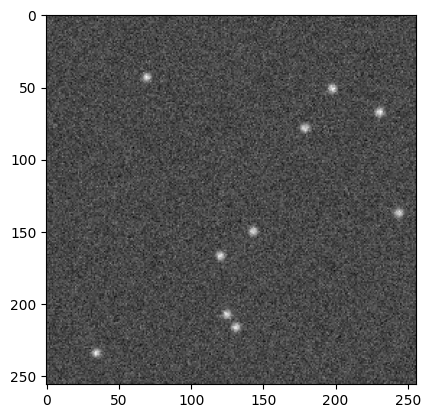

In [7]:
for i in range(4):
    image_features.update()
    output_image = image_features.plot(cmap="gray")

## 7. Create the target images

We define a function that uses the generated images to create the target images to be used in the training. Here the target image is binary image, where each pixel is `1` if it is within `CIRCLE_RADIUS` distance from any particle in the input image, and 0 otherwise.

In [8]:
# Creates an image with circles of radius two at the same position
# as the particles in the input image.
image_features.store_properties()
circle_radius = 3

def get_target_image(image_of_particles):
    target_image = np.zeros(image_of_particles.shape)
    x, y = np.meshgrid(
        np.arange(0, image_of_particles.shape[0]),
        np.arange(0, image_of_particles.shape[1])
    )

    for property in image_of_particles.properties:
        if "position" in property:
            position = property["position"]

            distance_map = (x - position[1]) ** 2 + (y - position[0]) ** 2
            target_image[distance_map < circle_radius ** 2] = 1

    return target_image

Here, we show images and targets side by side.

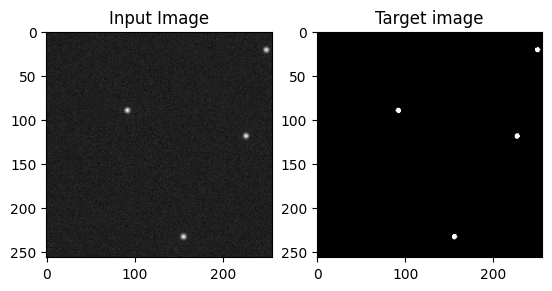

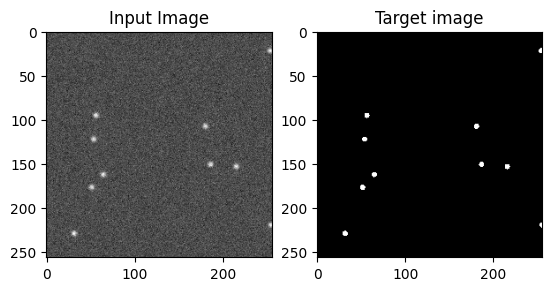

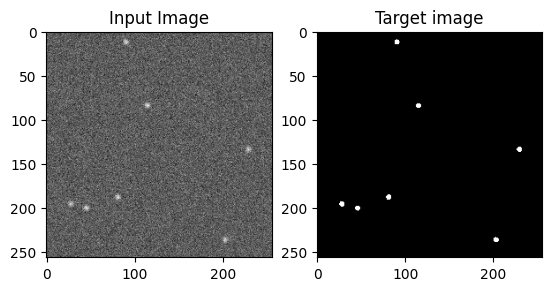

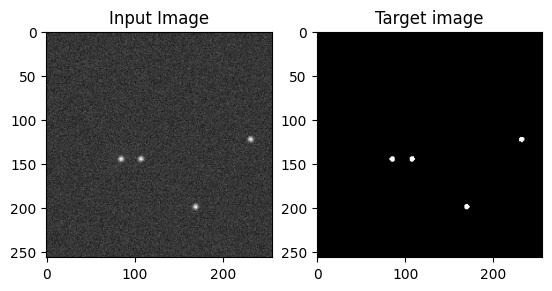

In [9]:
for i in range(4):
    image_features.update()
    image_of_particles = image_features.resolve()

    target_image = get_target_image(image_of_particles)

    plt.subplot(1,2,1)
    plt.imshow(np.squeeze(image_of_particles), cmap="gray")
    plt.title("Input Image")

    plt.subplot(1,2,2)
    plt.imshow(np.squeeze(target_image), cmap="gray")
    plt.title("Target image")

    plt.show()

## 9. Define the neural network model

The neural network architecture used is a U-Net, which is a fully convolutional model used for image-to-image transformations. We create this model by calling the function `unet` (see also [models_example](../module-examples/models_example.ipynb)).

Since the desired output is a binary image, we will be using crossentropy as loss. Furthermore, since the target image is disproportionaly populated by 0s (any pixel is much more likely to be a zero than a one), we weight the loss such that false negatives are penalized ten times more than the false positives.

The model can be customized by passing the following arguments:

* `input_shape`: Size of the images to be analyzed. The first two values can be set to `None` to allow arbitrary sizes.

* `conv_layers_dimensions`: Number of convolutions in each convolutional layer during down-
    and upsampling.
    
* `base_conv_layers_dimensions`: Number of convolutions in each convolutional layer at the base
    of the unet, where the image is the most downsampled.

* `output_conv_layers_dimensions`: Number of convolutions in each convolutional layer after the
    upsampling.
    
* `steps_per_pooling`: Number of convolutional layers between each pooling and upsampling
    step.

* `number_of_outputs`: Number of convolutions in output layer.

* `output_activation`: The activation function of the output.

* `loss`: The loss function of the network.

* `optimizer`: The the optimizer used for training.

* `metrics`: Additional metrics to evaulate during training.

In [10]:
import deeptrack.deeplay as dl
import torchmetrics as tm

data_pipeline = image_features & (image_features >> get_target_image)

net = dl.UNet2d(
    in_channels=1,
    channels=[16, 32, 64],
    out_channels=1,
)

weight = dl.torch.tensor([500])
model = dl.Regressor(
    net,
    loss=dl.torch.nn.BCEWithLogitsLoss(pos_weight=weight),
    optimizer=dl.optimizers.Adam(lr=1e-4),
    metrics=[tm.F1Score(task="binary")],
)

## 10. Train the model

The model is trained by calling `.fit()`. This will take a few minutes.

In [ ]:
h = model.fit(
            train_data=data_pipeline,
            val_data=data_pipeline,
            max_epochs=100,
            steps_per_epoch=25,
            val_steps_per_epoch=5,
            accelerator="cuda",
            )

┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type              ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ BCEWithLogitsLoss │      0 │ train │
│ 1 │ train_metrics │ MetricCollection  │      0 │ train │
│ 2 │ val_metrics   │ MetricCollection  │      0 │ train │
│ 3 │ test_metrics  │ MetricCollection  │      0 │ train │
│ 4 │ model         │ UNet2d            │  128 K │ train │
│ 5 │ optimizer     │ Adam              │      0 │ train │
└───┴───────────────┴───────────────────┴────────┴───────┘

Trainable params: 128 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 128 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 45                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches 
(25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if
you want to see logs for the training epoch.

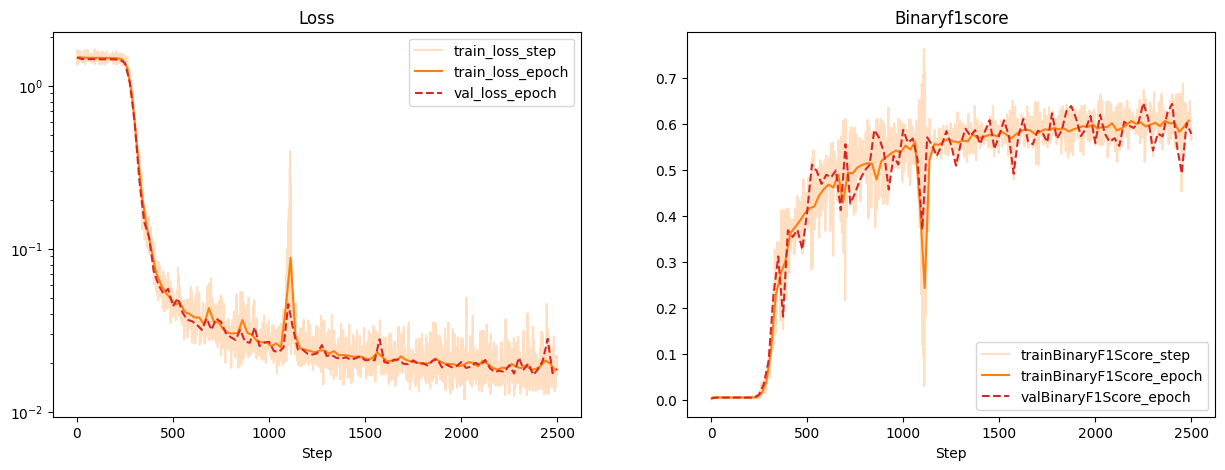

In [12]:
fig, ax = h.plot()
ax[0].set_yscale("log")
ax[1].set_yscale("linear")

## 11. Visualize the model performance

Finally, we evaluate the model performance by showing the model output besides the input image and the target image.

1190.5636363636363


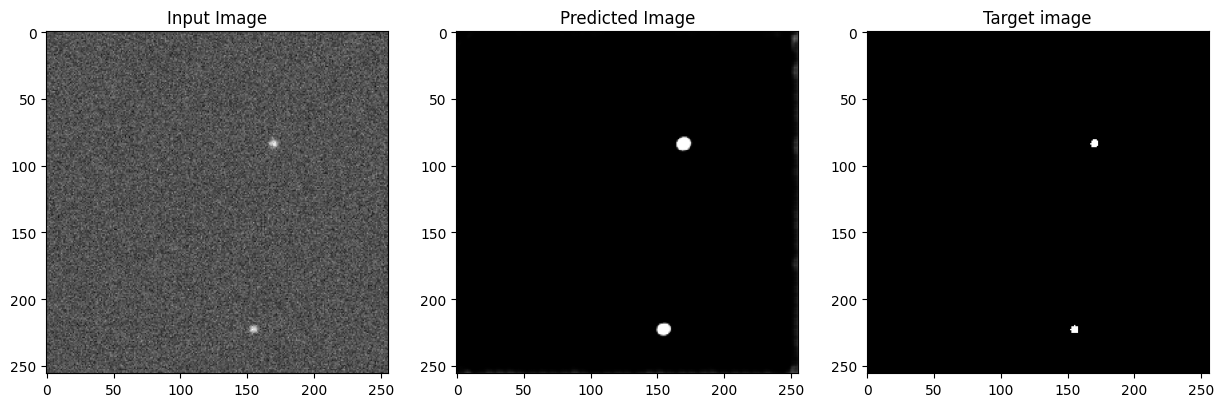

382.2514619883041


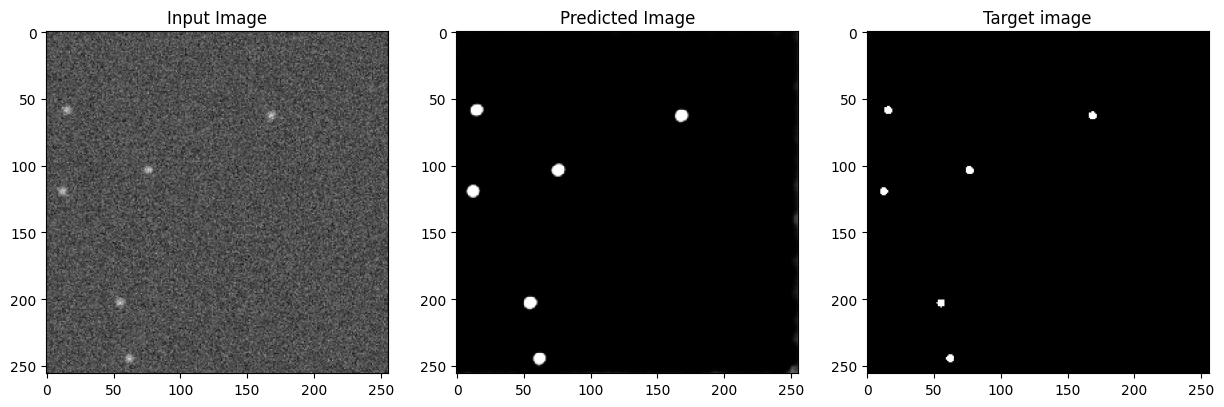

328.32663316582915


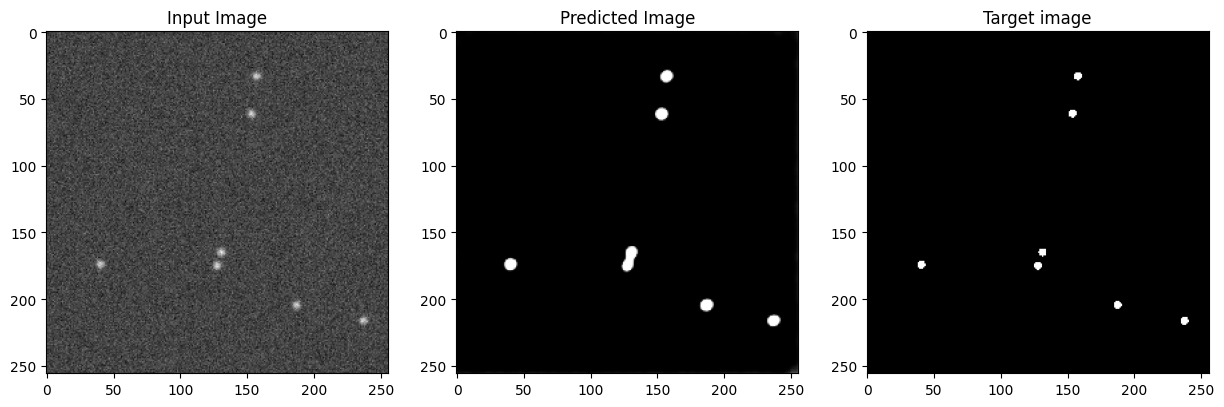

2519.6153846153848


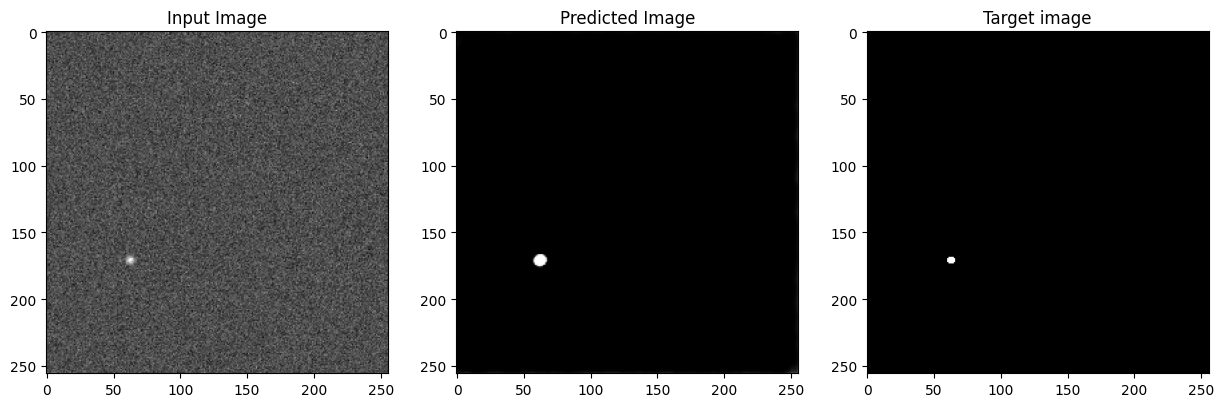

In [13]:
images, targets = data_pipeline.batch(4)
predicted_probabilities =\
 model.predict(np.transpose(images,(0,3,2,1)).astype(np.float32)).sigmoid()

for i in range(4):

    plt.figure(figsize=(15, 5))
    plt.subplot(1,3,1)
    plt.imshow(images[i, ..., 0].squeeze(), cmap="gray")
    plt.title("Input Image")

    plt.subplot(1,3,2)
    plt.imshow(predicted_probabilities[i, 0, ...].T, cmap="gray")
    plt.title("Predicted Image")

    plt.subplot(1,3,3)
    plt.imshow(targets[i], cmap="gray")
    plt.title("Target image")
    print((targets[i] == 0).sum() / (targets[i] == 1).sum())

    plt.show()